In [36]:
import numpy
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import shapely

In [75]:
# get an ATL06 

! wget https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2018/11/23/ATL06_20181123183949_08570111_006_02.h5

--2025-08-19 21:25:51--  https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2018/11/23/ATL06_20181123183949_08570111_006_02.h5
Resolving data.nsidc.earthdatacloud.nasa.gov (data.nsidc.earthdatacloud.nasa.gov)... 18.161.6.24, 18.161.6.88, 18.161.6.83, ...
Connecting to data.nsidc.earthdatacloud.nasa.gov (data.nsidc.earthdatacloud.nasa.gov)|18.161.6.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://urs.earthdata.nasa.gov/oauth/authorize?client_id=ntD0YGC_SM3Bjs-Tnxd7bg&response_type=code&redirect_uri=https://data.nsidc.earthdatacloud.nasa.gov/login&state=%2Fnsidc-cumulus-prod-protected%2FATLAS%2FATL06%2F006%2F2018%2F11%2F23%2FATL06_20181123183949_08570111_006_02.h5&app_type=401 [following]
--2025-08-19 21:25:51--  https://urs.earthdata.nasa.gov/oauth/authorize?client_id=ntD0YGC_SM3Bjs-Tnxd7bg&response_type=code&redirect_uri=https://data.nsidc.earthdatacloud.nasa.gov/login&state=%2Fnsidc-cumulus-prod-protected%2F

In [77]:
thefile = 'ATL06_20181123183949_08570111_006_02.h5'

In [65]:
def make_chunk_index(thefile):
    track_chunk_geom=[]
    with h5py.File(thefile,'r') as fh:
        for beam in [1,2,3]:
            for lr in ['l','r']:
                track=f'gt{beam}{lr}'
                t_group=fh[track]['land_ice_segments']
                dsets = [t_group['longitude'], t_group['latitude']]
                for chunk, i_latlon in enumerate(dsets[0].iter_chunks()):
                    lonlat = [dset[i_latlon] for dset in dsets]
                    bbox = [np.array([np.min(jj), np.max(jj)]) for jj in lonlat]
                    geom = shapely.Polygon(np.c_[bbox[0][[0, 0, 1, 1, 0]], bbox[1][[0, 1, 1, 0, 0]]])
                    track_chunk_geom += [{'track':track,'chunk':chunk, 'geometry':geom}]
    return gpd.GeoDataFrame(track_chunk_geom)

In [66]:
%%time
gdf = make_chunk_index('ATL06/ATL06_20181123183949_08570111_006_02.h5')

CPU times: user 82.2 ms, sys: 13.6 ms, total: 95.8 ms
Wall time: 176 ms


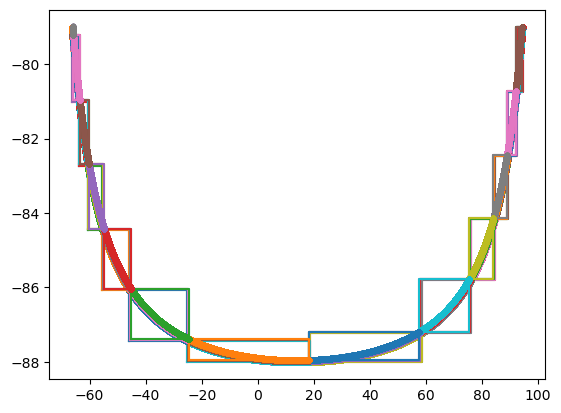

In [74]:
# plot a chunk index
plt.figure()
thefile='ATL06/ATL06_20181123183949_08570111_006_02.h5'
with h5py.File(thefile,'r') as fh:
    track_chunks = {}
    for track, chunk, geom in zip(gdf['track'], gdf['chunk'], gdf['geometry']):
        if track not in track_chunks:
            track_chunks[track]=list(fh[track]['land_ice_segments/latitude'].iter_chunks())
        ind=track_chunks[track][chunk]
        lat=fh[track]['land_ice_segments/latitude'][ind]
        lon=fh[track]['land_ice_segments/longitude'][ind]
        hl=plt.plot(lon, lat,'.')
        plt.plot(*np.c_[geom.exterior.coords].T, color=hl[0].get_color())

